In [49]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [50]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [51]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [52]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


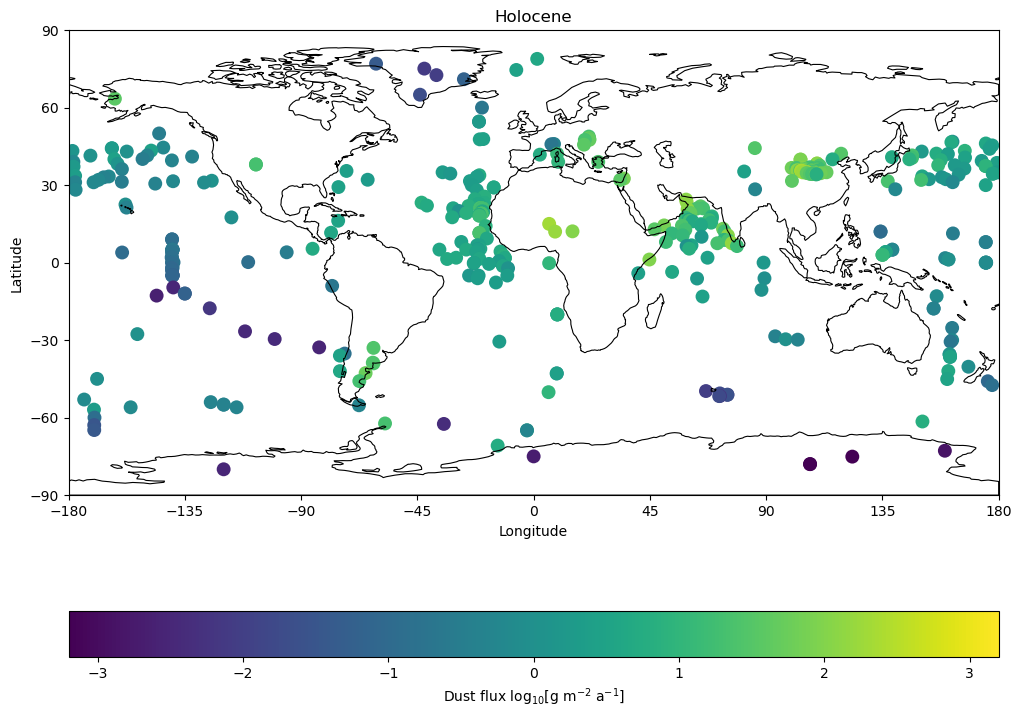

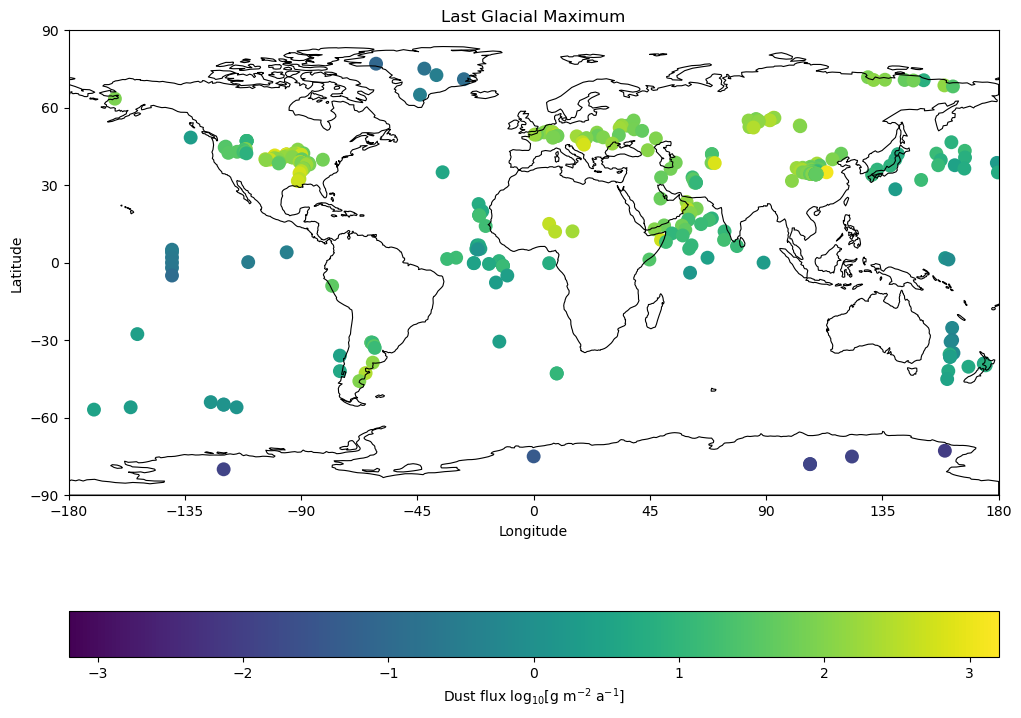

In [53]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [54]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

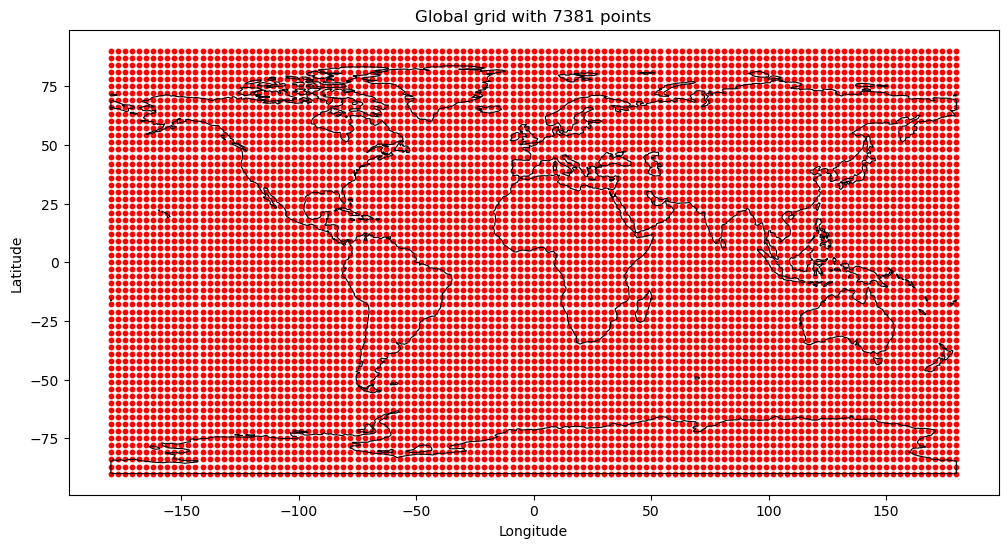

In [55]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [56]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

In [57]:
def distance_geodesic(x, y, R=6371):
    """
    Calcula la distancia geodésica entre dos puntos en la Tierra.

    Parametros:
    x, y : tuple
        Tuplas que representan la (latitud, longitud) de los dos puntos en grados.
    R : float, opcional
        Radio de la Tierra en kilómetros. (6371), que es el radio medio de la Tierra.
        (El radio de la tierra difiere dependiendo de que parte de la misma estemos midiendo,
    por esta razón básicamente hay tres radios diferentes: Radio Ecuatorial 6,378.1 km.
    Radio Polar 6,356.8 km. Radio Medio 6,371.0 km. usaremos el radio medio para esta funcion.
    Datos encontrados en internet.)
    '''
    Returns:
    float
        La distancia geodésica entre los dos puntos en kilómetros.
    """
    # Se convierten las latitudes y longitudes de grados a radianes 
    lat1, lon1 = np.radians(x)
    lat2, lon2 = np.radians(y)
    #calculamos diferencia
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    distance = R * np.arccos(np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(dlon))

    return distance

In [58]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Realisa la estimación de k vecino más cercano.

    Parametros:
    df : pandas.DataFrame
        Database.
    x : Iterable
        Ubicación para la estimación.
    k : int
        El número de vecinos a considerar.
    dist : str
        El tipo de definición de distancia.
    """
    
    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean
    
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]
    
    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)
    
    return estimation

In [59]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

In [60]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol"] = estimations_holocene
df_global_grid["est_lgm"] = estimations_lgm



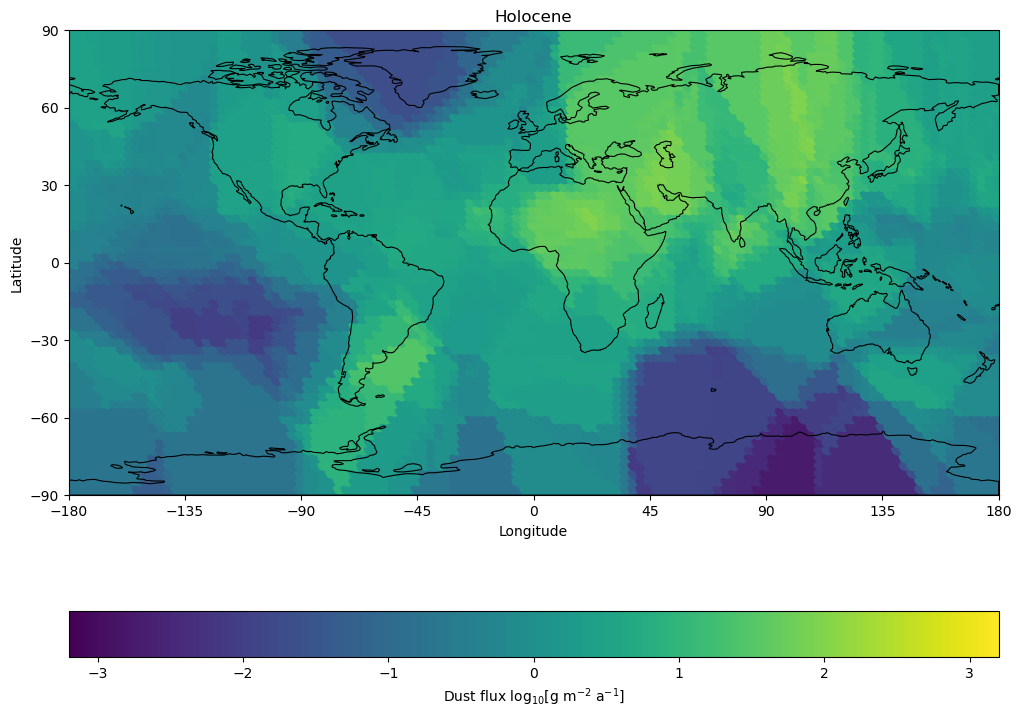

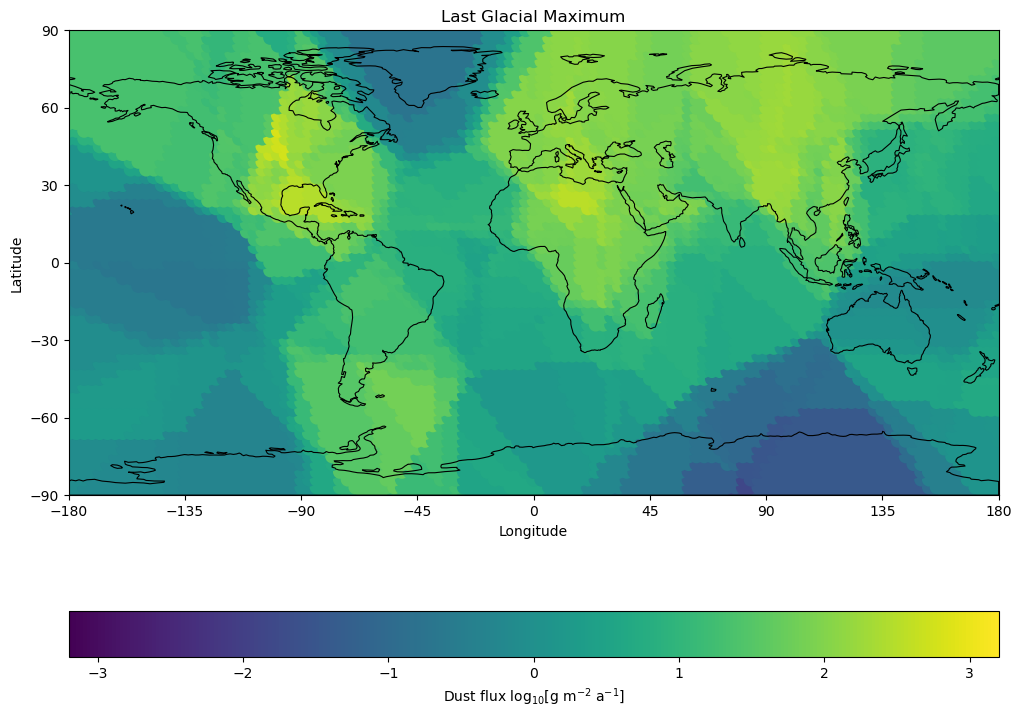

In [61]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm')

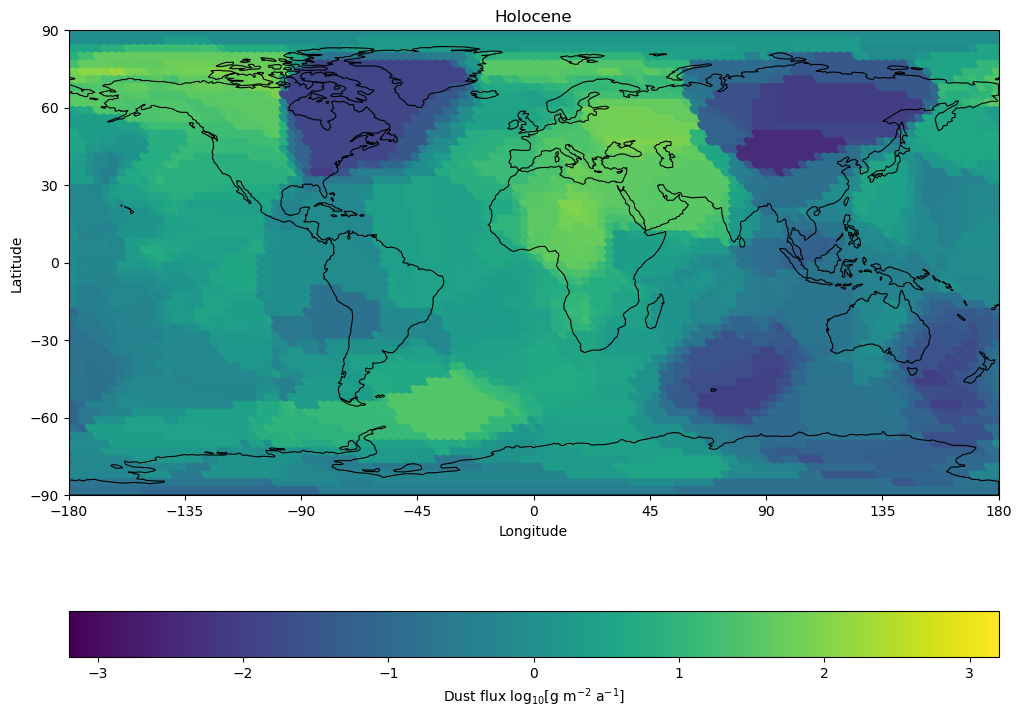

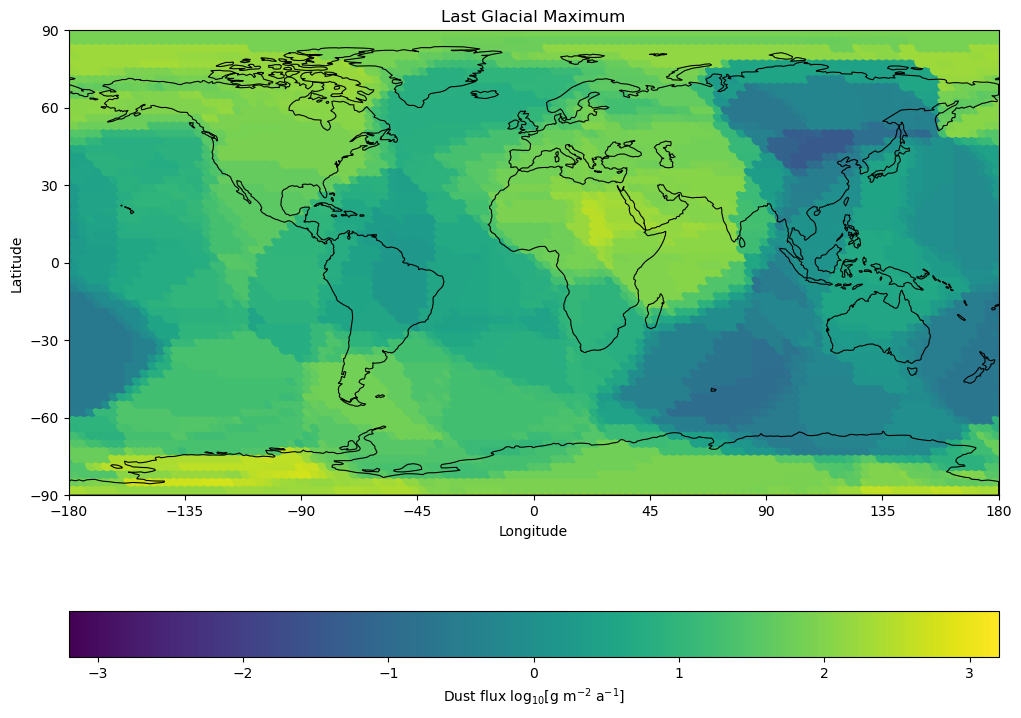

In [62]:
# Calculamos estimaciones con distancia geodesica
estimations_geodesic_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_geodesic_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lat"], row["lon"])
    estimations_geodesic_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_geodesic_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

# Asignamos las estimaciones al DataFrame df_global_grid
df_global_grid["est_hol"] = estimations_geodesic_holocene
df_global_grid["est_lgm"] = estimations_geodesic_lgm

# Visualizamos las estimaciones en mapas
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE_GEODESIC',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM_GEODESIC',
                         label_str='est_lgm')

In [63]:
# Calculamos las estimaciones con distancia euclidiana
estimations_euclidean_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_euclidean_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_euclidean_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_euclidean_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

# Calculamms las estimaciones con distancia geodesica
estimations_geodesic_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_geodesic_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_geodesic_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_geodesic_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

# Calculamos la diferencia entre las estimaciones euclidianas y geodesicas
difference_holocene = estimations_euclidean_holocene - estimations_geodesic_holocene
difference_lgm = estimations_euclidean_lgm - estimations_geodesic_lgm

# Asignamos las diferencias al DataFrame global
df_global_grid["difference_holocene"] = difference_holocene
df_global_grid["difference_lgm"] = difference_lgm


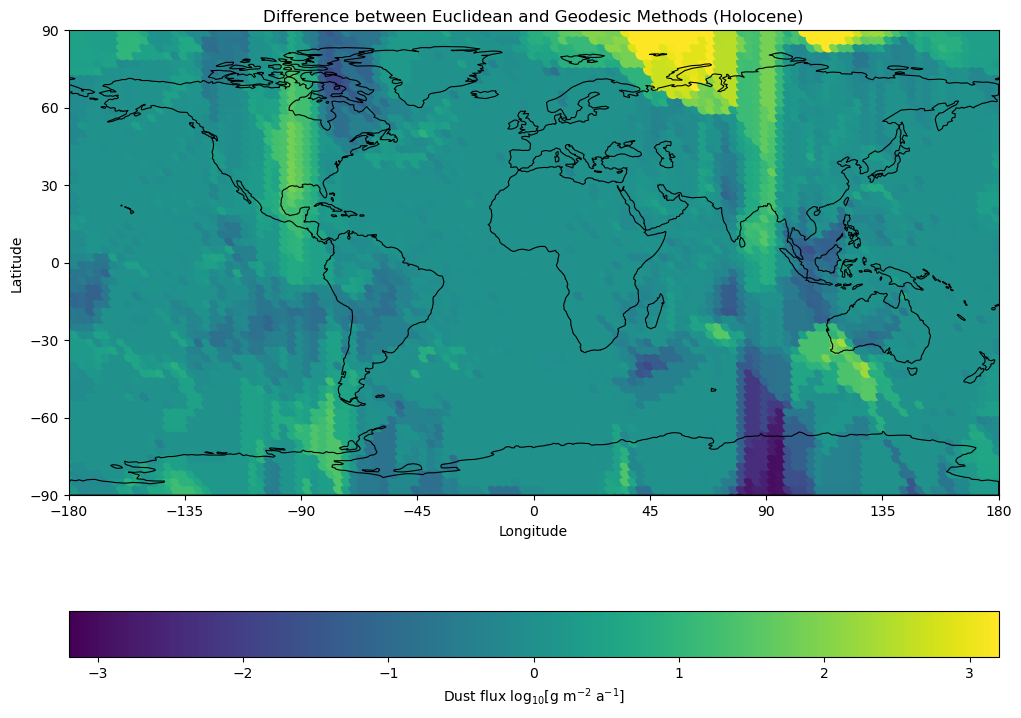

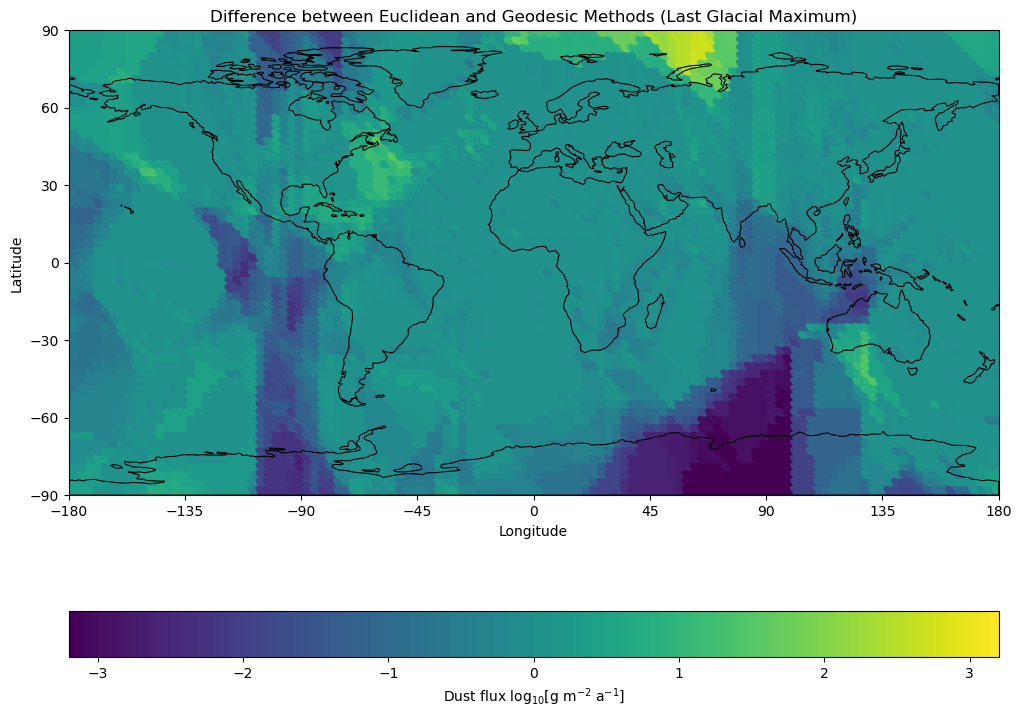

In [64]:
# Visualizamos la diferencia en un mapa
plot_dust_deposition_map(df=df_global_grid,
                         title='Difference between Euclidean and Geodesic Methods (Holocene)',
                         name_to_save='DIFFERENCE_MAP_HOLOCENE',
                         label_str='difference_holocene')

plot_dust_deposition_map(df=df_global_grid,
                         title='Difference between Euclidean and Geodesic Methods (Last Glacial Maximum)',
                         name_to_save='DIFFERENCE_MAP_LGM',
                         label_str='difference_lgm')


## a) ¿Por que las diferencias son mas grandes en una parte que otra parte del mundo?
Esto puede ocurrir por diferentes razones, una de estas puede ser porque no en todos los lugares se recolectan la misma cantidad de datos, entonces al momento de usar las estimaciones de vecino mas cercano (nearest_neighbour_estimation) tendriamos una estimacion no 100% precisas, por eso es que podemos modificar el numero de vecinos cercanos. Tambien es posible que por la forma geologica de cada lugar (ya que no todos los datos son recolectados desde las mismas condiciones) afecte en los resultados optenidos, mostrando de esta forma diferencias notorias.

## b) ¿Cual metodo es mas fidedigno en los polos sur y norte?
En los polos norte y sur, la distancia entre los puntos de muestreo puede ser significativamente menor que en otras regiones debido a la convergencia de meridianos. En estas áreas, la distancia euclidiana puede ser más apropiada ya que la Tierra se puede aproximar a una superficie plana a pequeña escala. Sin embargo, en latitudes más bajas donde la curvatura de la Tierra es más significativa, la distancia geodésica sería más precisa. #chatgpt ayudo en la solucion de la respuesta y con ayuda de informacion de internet.

## c) ¿Cual metodo es mas fidedigno en longitud 180◦?
En longitud 180°, la distancia euclidiana podría producir estimaciones incorrectas debido a la discontinuidad en la proyección de la superficie de la Tierra. Entonces el uso de la distancia geodésica sería la mejor para manejar este caso. (ya que tiene en cuenta la curvatura de la Tierra y la verdadera distancia entre los puntos a lo largo de la superficie esférica). 


## d) ¿Cuales son las diferencias entre los resultados para el Holoceno y el LGM?
Las diferencias entre los resultados para el Holoceno (época geológica actual) y el Último Máximo Glacial (LGM) podrían ser significativas debido a cambios en la distribución de las masas de hielo, los patrones climáticos y las condiciones atmosféricas entre estos períodos, todos estos cambios pueden influir en la medicion de la deposion de polvo, afectando a las estimaciones realizadas por el programa.

## e) ¿Como elegir el numero de vecinos cercanos?
Para la seleccion del numero de vecinos cercano este puede depender de diferentes factores, como por ejemplo la dencidad de los datos y su distribucion.
Segun entendi antes de elegir el numero que se utilizara se hacen pruebas con diferentes numeros (para vecinos cercanos) para determinal cual entrega los mejores datos (que sea mas preciso)o los mas optimos segun en que se quieran usar. 

{Generalmente, se realiza una validación cruzada o se prueban varios valores de k para determinar cuál produce los mejores resultados en términos de precisión del modelo. Además, se debe considerar el sesgo-varianza trade-off: un valor pequeño de k puede producir estimaciones ruidosas (alta varianza) mientras que un valor grande de k puede producir estimaciones sesgadas (alta sesgo).}#segun internet

## Utilize chatGPT3.5 para el desarrollo de esta tarea. 
Principalente para comprender mejor que hacia el codigo ya existente(tarea1-ejemplo) y para la parte de crear la diferencia entre los dos metodos, por ultimo con el codigo que se entrego(tarea1-ejemplo), cree los demas puntos que se pedian, los cuales para ver si estaban bien redactados le preguntaba al chatgpt que si tenia errores de logica o de sintaxis.
Tambien use como fuente externa el pdf de donde se origina la tarea(https://arxiv.org/pdf/2401.14372.pdf ) esto ya que me parecia informacion importante para el desarrollo de la tarea.
Trabaje directamente arriba del archivo de tarea1-ejemplo.